# Import the libraries

In [54]:
# Importing the necessary libraries
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as sns

from sklearn.preprocessing import StandardScaler
%matplotlib inline

from tensorflow import keras
from tensorflow.keras import layers
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import tensorflow as tf
print('tensorflow version =',tf.__version__)

tensorflow version = 2.0.0


# Loading and preparing the Data

In [55]:
data=pd.read_csv("data.csv",parse_dates=[0])
data = data.set_index("Datetime") # set Datetime as an index
data=data.dropna()
data.head()

,Market_price,Actual_load
Datetime,,
2019-01-01 01:00:00,28.32,9920.0
2019-01-01 02:00:00,10.07,9845.0
2019-01-01 03:00:00,10.03,9913.0
2019-01-01 04:00:00,4.56,10027.0
2019-01-01 05:00:00,4.83,9967.0


In [56]:
# slicing date column for plotting purposes
train_dates=data.reset_index()
train_dates=train_dates['Datetime']


In [57]:
# Normalizing and scaling the dataset 
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)


In [58]:
# splitting dataset into train and test parts
training_size=int(len(scaled_data)*0.80)
test_size=len(scaled_data)-training_size
train_data,test_data=scaled_data[0:training_size,:],scaled_data[training_size:len(scaled_data),:]
train_data.shape,test_data.shape

((9382, 2), (2346, 2))

## 1.Actual_load prediction

In [59]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, timestep=1):
    X_data, Y_data = [], []
    for i in range(timestep, len(dataset) - n_future +1):
        X_data.append(dataset[i - timestep:i, 0:data.shape[1]])
        Y_data.append(dataset[i + n_future - 1:i + n_future, 1])
    return np.array(X_data), np.array(Y_data)

In [60]:
n_future = 1   # Number of hours we want to predict into the future
timestep = 10    # Number of past hours we want to use to predict the future

#train data
trainX,trainY= create_dataset(train_data, timestep)
print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))
#test data
testX,testY= create_dataset(test_data, timestep)
print('testX shape == {}.'.format(testX.shape))
print('testY shape == {}.'.format(testY.shape))

trainX shape == (9372, 10, 2).
trainY shape == (9372, 1).
testX shape == (2336, 10, 2).
testY shape == (2336, 1).


In [61]:
# define model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))

model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 10, 64)            17152     
_________________________________________________________________
lstm_10 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 29,601
Trainable params: 29,601
Non-trainable params: 0
_________________________________________________________________


In [62]:
# fit the model
history = model.fit(trainX, trainY, epochs=20, batch_size=32, validation_data=(testX,testY), verbose=1)

Train on 9372 samples, validate on 2336 samples
Epoch 1/20
9372/9372 [==============================] - 20s 2ms/step - loss: 0.2307 - val_loss: 0.0567
Epoch 2/20
9372/9372 [==============================] - 17s 2ms/step - loss: 0.0633 - val_loss: 0.0235
Epoch 3/20
9372/9372 [==============================] - 17s 2ms/step - loss: 0.0455 - val_loss: 0.0185
Epoch 4/20
9372/9372 [==============================] - 16s 2ms/step - loss: 0.0443 - val_loss: 0.0169
Epoch 5/20
9372/9372 [==============================] - 18s 2ms/step - loss: 0.0436 - val_loss: 0.0196
Epoch 6/20
9372/9372 [==============================] - 16s 2ms/step - loss: 0.0421 - val_loss: 0.0159
Epoch 7/20
9372/9372 [==============================] - 16s 2ms/step - loss: 0.0389 - val_loss: 0.0141
Epoch 8/20
9372/9372 [==============================] - 15s 2ms/step - loss: 0.0382 - val_loss: 0.0193
Epoch 9/20
9372/9372 [==============================] - 16s 2ms/step - loss: 0.0378 - val_loss: 0.0188
Epoch 10/20
9372/9372 [==

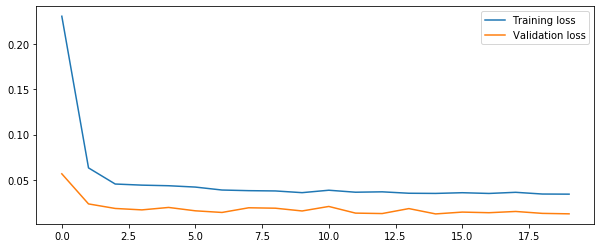

In [63]:
# Loss Vs validation 
plt.figure(figsize=(10,4))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

### 1.1 predicting training data

In [64]:
#Model validation
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error


predicted_train = model.predict(trainX)

r2_train = r2_score(trainY, predicted_train)
rmse_train = mean_squared_error(trainY, predicted_train)

print('the tainig set accaurcy is ............', round(r2_train,2))
print('Root mean square error is...', round(rmse_train,2))


the tainig set accaurcy is ............ 0.99
Root mean square error is... 0.01


In [65]:
# retransform the predicted training data into normal values(unscaled values) 
predicted_copies = np.repeat(predicted_train, data.shape[1], axis=-1)
predicted_train = scaler.inverse_transform(predicted_copies)

x=train_dates.iloc[:len(train_data)] # assigning the date 
x=x.reset_index(drop=True)

predicted_train=pd.DataFrame(predicted_train) # transforming predicted_train into dataframe
predicted_train['Datetime']=x

predicted_train=predicted_train.iloc[:,[2,0,1]] #rearrange the columns
predicted_train.head(1)

,Datetime,0,1
0,2019-01-01 01:00:00,49.438431,10516.595703


In [66]:
original =data[['Market_price','Actual_load']]
original.head(1)

,Market_price,Actual_load
Datetime,,
2019-01-01 01:00:00,28.32,9920.0


Text(0, 0.5, 'Energy(MWh)')

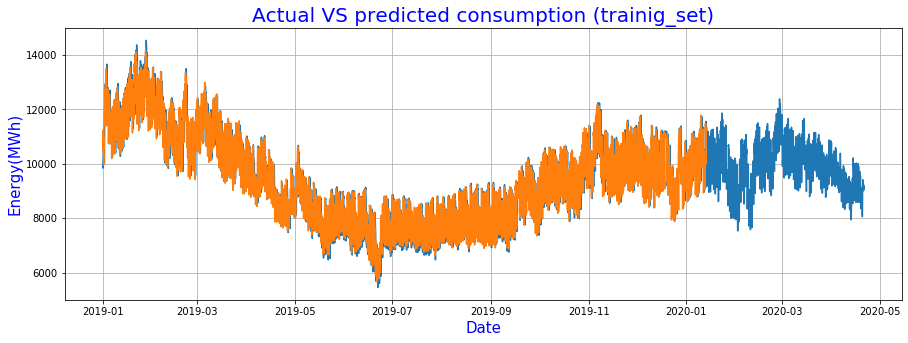

In [67]:
# plotting 
plt.figure(figsize=(15,5))
plt.grid(True)

sns.lineplot(original.index, original.iloc[:,1])
sns.lineplot(predicted_train['Datetime'], predicted_train.iloc[:,2])

plt.title('Actual VS predicted consumption (trainig_set)',color='blue',size=(20))
plt.xlabel('Date',color='blue',size = 15)
plt.ylabel('Energy(MWh)',color='blue',size = 15)



### 1.2 predicting test data

In [68]:
predicted_test= model.predict(testX)

r2_test = r2_score(testY, predicted_test)
rmse_test = mean_squared_error(testY, predicted_test)

print('The test accuracy  is............', round(r2_test,2))
print('Root mean square error is...', round(rmse_test,2))


The test accuracy  is............ 0.96
Root mean square error is... 0.01


In [69]:
predicted_copies = np.repeat(predicted_test, data.shape[1], axis=-1)
predicted_test = scaler.inverse_transform(predicted_copies)

x=train_dates.iloc[len(train_data):]
x=x.reset_index(drop=True)

predicted_test=pd.DataFrame(predicted_test)
predicted_test['Datetime']=x

predicted_test=predicted_test.iloc[:,[2,0,1]]
predicted_test.tail(1)

,Datetime,0,1
2335,2020-04-20 10:00:00,35.290508,9315.732422


In [70]:
#define the index of 20.02.2020 to use it in plotting to show 2 months prediction 
y=predicted_test.loc[predicted_test['Datetime'].isin(['2020-02-20 06:00:00'])].iloc[:,:]
y

,Datetime,0,1
894,2020-02-20 06:00:00,61.45747,11536.761719


Text(0, 0.5, 'Energy(MWh)')

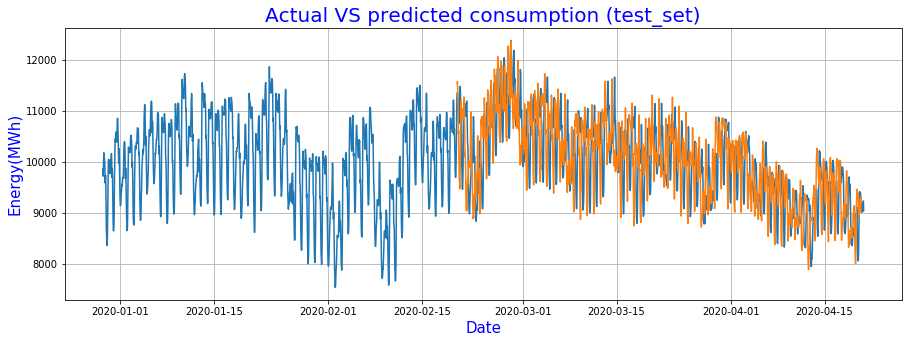

In [71]:
plt.figure(figsize=(15,5))
plt.grid(True)

# 2 months prediction plot starting from 20.2.20
sns.lineplot(original.index[9000:], original.iloc[9000:,1])
sns.lineplot(predicted_test['Datetime'], predicted_test.iloc[894:,2]) 

plt.title('Actual VS predicted consumption (test_set)',color='blue',size=(20))
plt.xlabel('Date',color='blue',size = 15)
plt.ylabel('Energy(MWh)',color='blue',size = 15)


## 2.Market price prediction

In [88]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, timestep=1):
    X_data, Y_data = [], []
    for i in range(timestep, len(dataset) - n_future +1):
        X_data.append(dataset[i - timestep:i, 0:data.shape[1]])
        Y_data.append(dataset[i + n_future - 1:i + n_future, 0])
    return np.array(X_data), np.array(Y_data)

In [89]:
n_future = 1  
timestep = 10   

#train data
trainX1,trainY1= create_dataset(train_data, timestep)
print('trainX1 shape == {}.'.format(trainX1.shape))
print('trainY1 shape == {}.'.format(trainY1.shape))
#test data
testX1,testY1= create_dataset(test_data, timestep)
print('testX1 shape == {}.'.format(testX1.shape))
print('testY1 shape == {}.'.format(testY1.shape))

trainX1 shape == (9372, 10, 2).
trainY1 shape == (9372, 1).
testX1 shape == (2336, 10, 2).
testY1 shape == (2336, 1).


In [90]:
# define model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(testX1.shape[1], testX1.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY1.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 10, 64)            17152     
_________________________________________________________________
lstm_14 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dropout_7 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 29,601
Trainable params: 29,601
Non-trainable params: 0
_________________________________________________________________


In [91]:
# fit model
history1 = model.fit(trainX1, trainY1, epochs=20, batch_size=32, validation_data=(testX1,testY1), verbose=1)

Train on 9372 samples, validate on 2336 samples
Epoch 1/20
9372/9372 [==============================] - 21s 2ms/step - loss: 0.3336 - val_loss: 0.1671
Epoch 2/20
9372/9372 [==============================] - 16s 2ms/step - loss: 0.1852 - val_loss: 0.1254
Epoch 3/20
9372/9372 [==============================] - 16s 2ms/step - loss: 0.1468 - val_loss: 0.1623
Epoch 4/20
9372/9372 [==============================] - 17s 2ms/step - loss: 0.1381 - val_loss: 0.1537
Epoch 5/20
9372/9372 [==============================] - 16s 2ms/step - loss: 0.1425 - val_loss: 0.1438
Epoch 6/20
9372/9372 [==============================] - 15s 2ms/step - loss: 0.1284 - val_loss: 0.1293
Epoch 7/20
9372/9372 [==============================] - 17s 2ms/step - loss: 0.1278 - val_loss: 0.1610
Epoch 8/20
9372/9372 [==============================] - 17s 2ms/step - loss: 0.1344 - val_loss: 0.1272
Epoch 9/20
9372/9372 [==============================] - 17s 2ms/step - loss: 0.1263 - val_loss: 0.1736
Epoch 10/20
9372/9372 [==

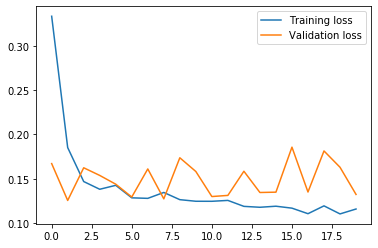

In [92]:
plt.plot(history1.history['loss'], label='Training loss')
plt.plot(history1.history['val_loss'], label='Validation loss')
plt.legend()

### 2.1 Training set

In [93]:
#Model validation
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

#predicting training data
predicted_train1 = model.predict(trainX1)

r2_train1 = r2_score(trainY1, predicted_train1)
rmse_train1 = mean_squared_error(trainY1, predicted_train1)

print('the trainig set accaurcy is ............', round(r2_train1,2))
print('Root mean square error is...', round(rmse_train1,2))

the trainig set accaurcy is ............ 0.89
Root mean square error is... 0.09


In [94]:
# retransform the predicted training data into normal values(unscaled values) 
predicted_copies1 = np.repeat(predicted_train1, data.shape[1], axis=-1)
predicted_train1 = scaler.inverse_transform(predicted_copies1)

x=train_dates.iloc[:len(train_data)] # assiging the date 
x=x.reset_index(drop=True)

predicted_train1=pd.DataFrame(predicted_train1) # transforming predicted_train into dataframe
predicted_train1['Datetime']=x

predicted_train1=predicted_train1.iloc[:,[2,0,1]] #re-arrange the columns
predicted_train1.head(1)

,Datetime,0,1
0,2019-01-01 01:00:00,17.874636,7837.487793


Text(0, 0.5, 'Price(€/MWh)')

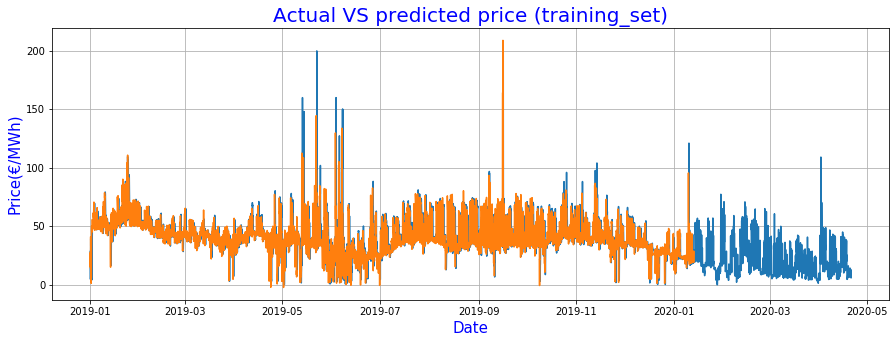

In [95]:
plt.figure(figsize=(15,5))
plt.grid(True)

sns.lineplot(original.index, original.iloc[:,0])
sns.lineplot(predicted_train1['Datetime'], predicted_train1.iloc[:,1])

plt.title('Actual VS predicted price (training_set)',color='blue',size=(20))
plt.xlabel('Date',color='blue',size = 15)
plt.ylabel('Price(€/MWh)',color='blue',size = 15)

### 2.2 test set

In [96]:
predicted_test1= model.predict(testX1)

r2_test1 = r2_score(testY1, predicted_test1)
rmse_test1 = mean_squared_error(testY1, predicted_test1)

print('the test set accaurcy is ............', round(r2_test1,2))
print('Root mean square error is...', round(rmse_test1,2))



the test set accaurcy is ............ 0.8
Root mean square error is... 0.13


In [97]:
predicted_copies1 = np.repeat(predicted_test1, data.shape[1], axis=-1)
predicted_test1 = scaler.inverse_transform(predicted_copies1)

x=train_dates.iloc[len(train_data):]
x=x.reset_index(drop=True)

predicted_test1=pd.DataFrame(predicted_test1)
predicted_test1['Datetime']=x


predicted_test1=predicted_test1.iloc[:,[2,0,1]]
predicted_test1.head(1)

,Datetime,0,1
0,2020-01-13 23:00:00,52.057735,10738.920898


Text(0, 0.5, 'Price(€/MWh)')

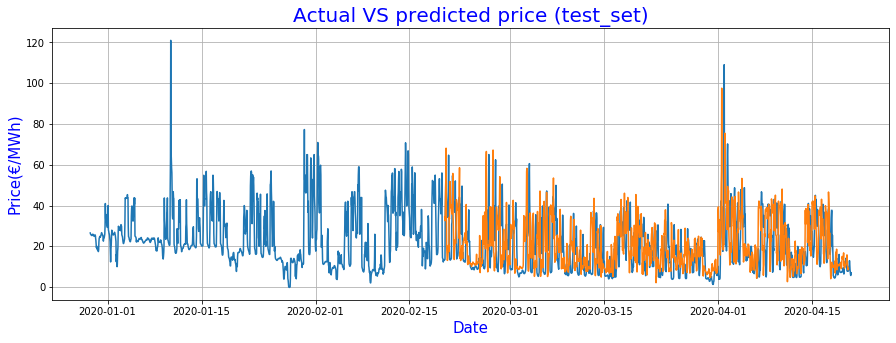

In [98]:
plt.figure(figsize=(15,5))
plt.grid(True)
# plotting 2 months prediction vs actual of market price
sns.lineplot(original.index[9000:], original.iloc[9000:,0])
sns.lineplot(predicted_test1['Datetime'], predicted_test1.iloc[894:,1]) 

plt.title('Actual VS predicted price (test_set)',color='blue',size=(20))
plt.xlabel('Date',color='blue',size = 15)
plt.ylabel('Price(€/MWh)',color='blue',size = 15)